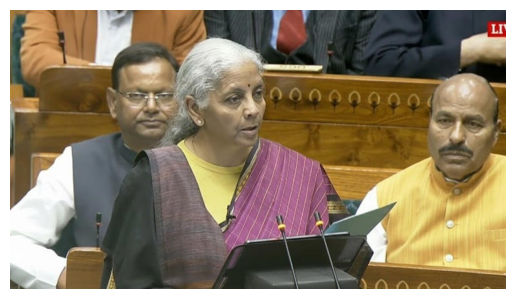

In [1]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("face.jpg")

if img is None:
    raise IOError("Image not found")

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [2]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
equalized = cv2.equalizeHist(blur)


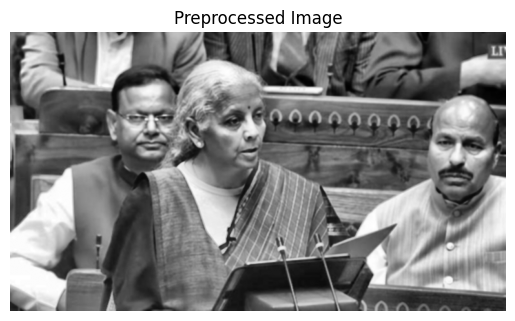

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

clahe = cv2.createCLAHE(2.0, (8,8))
preprocessed = clahe.apply(blur)

plt.imshow(preprocessed, cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()


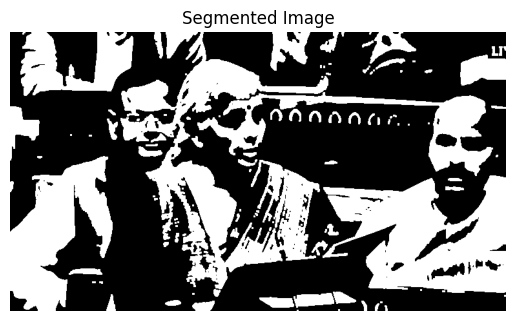

In [4]:
_, binary = cv2.threshold(
    preprocessed, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

plt.imshow(binary, cmap="gray")
plt.title("Segmented Image")
plt.axis("off")
plt.show()


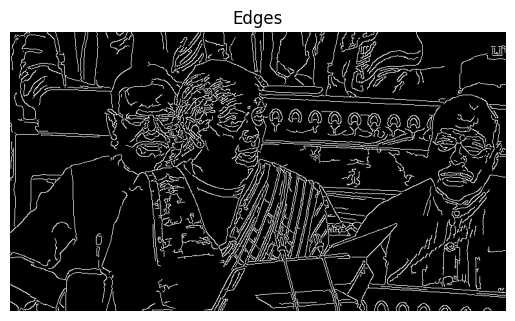

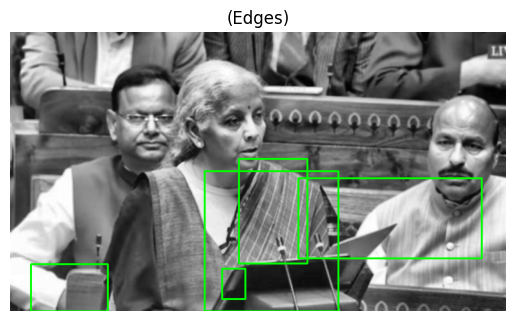

True

In [5]:
edges = cv2.Canny(preprocessed, 50, 150)

plt.imshow(edges, cmap="gray")
plt.title("Edges")
plt.axis("off")
plt.show()

contours, _ = cv2.findContours(
    edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

output = cv2.cvtColor(preprocessed, cv2.COLOR_GRAY2BGR)

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 300:
        continue

    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(output, (x,y), (x+w,y+h), (0,255,0), 2)

plt.imshow(output)
plt.title("(Edges)")
plt.axis("off")
plt.show()

cv2.imwrite("segmented_canny.jpg", output)


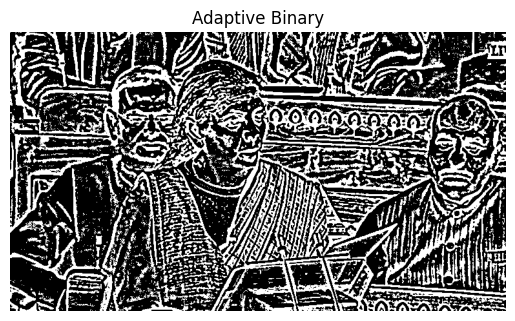

In [6]:
binary = cv2.adaptiveThreshold(
    preprocessed, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11, 2
)

plt.imshow(binary, cmap="gray")
plt.title("Adaptive Binary")
plt.axis("off")
plt.show()


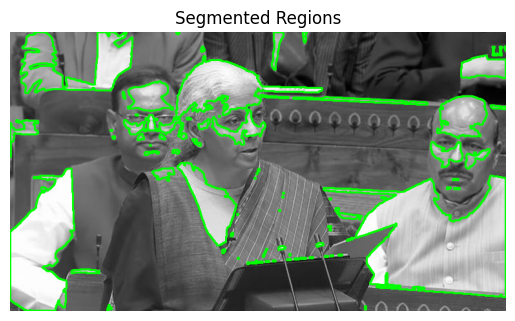

True

In [9]:
img = cv2.imread("face.jpg", cv2.IMREAD_GRAYSCALE)

if img is None:
    raise IOError("Image not found")

_, thresh = cv2.threshold(
    img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

contours, _ = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(output, contours, -1, (0, 255, 0), 2)

plt.imshow(output)
plt.title("Segmented Regions")
plt.axis("off")
plt.show()

cv2.imwrite("segmented.jpg", output)


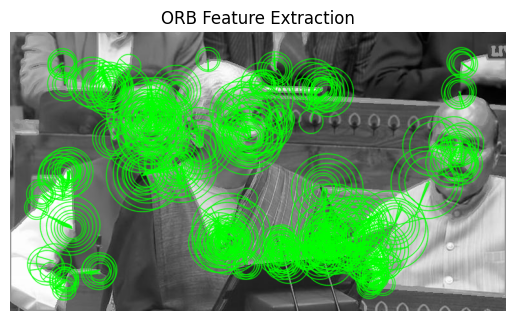

In [10]:
img = cv2.imread("segmented.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(img, None)

output = cv2.drawKeypoints(
    img, keypoints, None,
    color=(0,255,0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.imshow(output, cmap="gray")
plt.title("ORB Feature Extraction")
plt.axis("off")
plt.show()


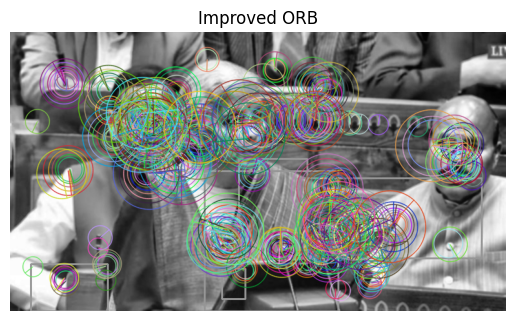

In [11]:
img = cv2.imread("segmented_canny.jpg", cv2.IMREAD_GRAYSCALE)
blur = cv2.GaussianBlur(img, (5,5), 0)

orb = cv2.ORB_create(nfeatures=500)
keypoints, descriptors = orb.detectAndCompute(blur, None)

output = cv2.drawKeypoints(
    img, keypoints, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.imshow(output, cmap="gray")
plt.title("Improved ORB")
plt.axis("off")
plt.show()


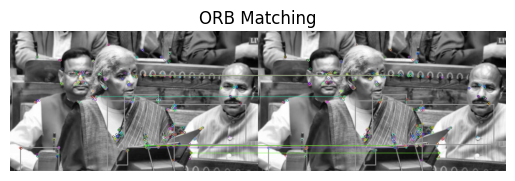

In [12]:
img1 = cv2.imread("segmented_canny.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("segmented_canny.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

matched = cv2.drawMatches(
    img1, kp1, img2, kp2,
    matches[:10], None
)

plt.imshow(matched, cmap="gray")
plt.title("ORB Matching")
plt.axis("off")
plt.show()


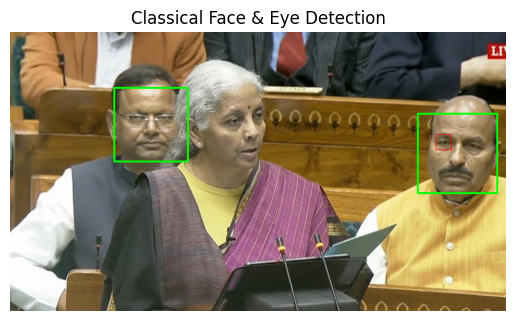

In [17]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("face.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
eye_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_eye.xml"
)

faces = face_cascade.detectMultiScale(gray, 1.1, 5)

for (x, y, w, h) in faces:
    # Face box (green)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img[y:y + h, x:x + w]

    # 🔥 Upper-half face ROI (eyes are NOT in chin)
    upper_face_gray = roi_gray[0:int(h * 0.5), :]

    eyes = eye_cascade.detectMultiScale(
        upper_face_gray,
        scaleFactor=1.05,
        minNeighbors=3,
        minSize=(15, 15)
    )

    for (ex, ey, ew, eh) in eyes:
        # Eye box (red)
        cv2.rectangle(
            roi_color,
            (ex, ey),
            (ex + ew, ey + eh),
            (0, 0, 255),
            1
        )
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Classical Face & Eye Detection")
plt.axis("off")
plt.show()

The system correctly identifies faces but struggles with eye detection because Haar eye classifiers are highly sensitive to pose, scale, and lighting. In crowded, non-frontal scenes like this, classical methods often miss or partially detect eyes despite accurate face localization.